In [65]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
import rasterio 
from scipy import stats
from IPython.display import Image
from pygeotools.lib import  iolib,geolib,warplib,malib
import skgstat as skg
from scipy.optimize import curve_fit
from scipy.optimize import leastsq, fmin_slsqp,least_squares

In [5]:
#Data_Files are 2 km buffer dh and the latest mb_csv to get the glacier area
csv_fn='hma_mb_20181108_0454_wregions.csv'
df_rgi=pd.read_csv(csv_fn)
datapath='/home/shashank/nobackup_shashank/HMA_Mb_Analysis/reprocessed_data/mb_20181108-20181111T192508Z-001/mb_20181108/test_glaciers/'
fn_list=[]
fl=[]
for file in os.listdir(datapath):
    fn_name=os.fsdecode(file)
    if fn_name.endswith('static.tif'):
        fl.append(fn_name.split('_')[0])
        fn_list.append(os.path.join(datapath,fn_name))

In [6]:
df_rgi['RGIId']=df_rgi['RGIId'].apply(lambda x: format(x,'#.7g'))

In [7]:
ma_list=[iolib.fn_getma(i) for i in fn_list]
gt_list=[iolib.fn_getds(i).GetGeoTransform() for i in fn_list]

In [8]:
def get_xyz(ma,gt,z,nscore=False):
    """
    Takes in a masked array gdal style gt & header for z
        
        returns a dataframe containing the x,y and the value of the raster
    """
    x,y=geolib.get_xy_ma(ma,gt,origmask=True)
    if nscore==True:
        df_nscored=GeostatsPy.nscore(ma.compressed(),np.shape(ma.compressed())[0])
        Z=df_nscored['NS:value'].values
    else:
        Z=ma.compressed()
    xyz=np.vstack((x.compressed(),y.compressed(),Z)).T
    df=pd.DataFrame(xyz,columns=['x','y',z])
    return(df)

In [9]:
def model_param(var,lag,gamma):
    """
     model for a spherical variogram, assuming sill at the variance of the data
     Takes in the variance, lag and gamma returned by GSLIB
     Returns sill,range and nugget
    """
    sill=var
    print('Sill=',sill)
    idx=np.argmax(np.array(gamma)>sill)
    print(idx)
    vrange=lag[idx]
    print("Range =",vrange)
    x=lag[0:4]
    y=gamma[0:4]
    slope,nugget,r,p,std=stats.linregress(x,y)
    print("Nugget=",nugget)
    return (sill,vrange,nugget)

In [10]:
def vario_plt(lag,gamma,lag_m,gamma_m,hrange,rgi_title):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--')
    ax.plot(lag_m,gamma_m,'g^')
    ax.axvline(x=hrange,color='blue',ymin=0,ymax=np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Variogram')
    ax.set_title(rgi_title)
    return fig
    

In [11]:
def variogram(rgi_title,df,x,y,val,nlag,lag_d,azi=0,tol=90,bstand=0):
    """
    Takes in a dataframe containing a x,y and values, variogram properties such as number of lags, lag distance,
    azimuth,azimuth tolerance and argument to standardize the sill or not
    
    Calulates variogram, which is then modelled for a spherical variogram, assuming sill at the variance of the data
    
    By Default calculates the omnidirectional varigram
    Calls in the variogram plotting function and plots the modelled and experimental variogram
    
    Returns the distance of autocorrelation and saves the plot
    """
    lag,gamma,npair=GeostatsPy.gamv_2d(df,x,y,val,nlag,lag_d,azi,tol,bstand)
    sill,hrange,c0=model_param(np.var(df[val]),lag,gamma)
    if c0<0:
        c0=0
    lag_m,gamma_m=GeostatsPy.vmodel_2d(nlag,lag_d,azi,c0,1,1,sill,azi,hrange,1)
    fig=vario_plt(lag,gamma,lag_m,gamma_m,hrange,rgi_title)
    fig_name=rgi_title+" variogram.png"
    fig.savefig(fig_name,dpi=300)
    return hrange
    

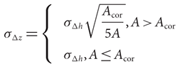

In [23]:
Image('Brun.gif')

In [24]:
def dh_er(ma,hrange,df,rgi_title):
    std=malib.print_stats(ma)[4]
    nmad=malib.print_stats(ma)[6]
    a_cor=np.pi*(hrange*hrange)
    a=(df.loc[df['RGIId']==rgi_title]).area_m2.values[0]
    if a>a_cor:
        sig_dh=std*np.sqrt(a_cor/(5*a))
    else:
        sig_dh=std
    print('dh_error =',sig_dh)
    return std,nmad,sig_dh
        

In [25]:
dh_df=get_xyz(ma_list[0],gt_list[0],'dh')

Sill= 0.9998989794164651
22
Range = 535.96
Nugget= -0.0032156878492819382
count: 13070 min: -43.90 max: 13.18 mean: -2.96 std: 6.30 med: -2.05 mad: 4.32 q1: -5.10 q2: 0.76 iqr: 5.86 mode: -4.34 p16: -7.07 p84: 2.01 spread: 4.54
count: 13070 min: -43.90 max: 13.18 mean: -2.96 std: 6.30 med: -2.05 mad: 4.32 q1: -5.10 q2: 0.76 iqr: 5.86 mode: -4.34 p16: -7.07 p84: 2.01 spread: 4.54
dh_error = 0.7524863731056173
Sill= 0.999978294538778
54
Range = 1350.893
Nugget= -0.0035690862900146225
count: 61210 min: -69.71 max: 83.82 mean: 3.23 std: 14.71 med: 2.02 mad: 11.24 q1: -5.25 q2: 10.02 iqr: 15.27 mode: 2.23 p16: -8.73 p84: 15.03 spread: 11.88
count: 61210 min: -69.71 max: 83.82 mean: 3.23 std: 14.71 med: 2.02 mad: 11.24 q1: -5.25 q2: 10.02 iqr: 15.27 mode: 2.23 p16: -8.73 p84: 15.03 spread: 11.88
dh_error = 3.605376939751376
Sill= 0.9999833257651763
178
Range = 5310.114
Nugget= -0.004741753166739332
count: 79515 min: -82.36 max: 77.01 mean: -0.27 std: 12.69 med: -0.47 mad: 9.34 q1: -6.55 q2: 

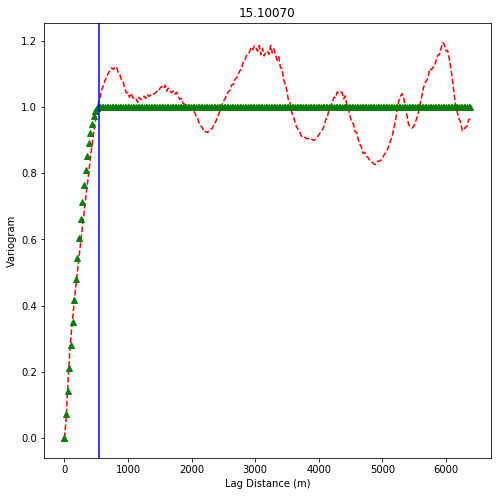

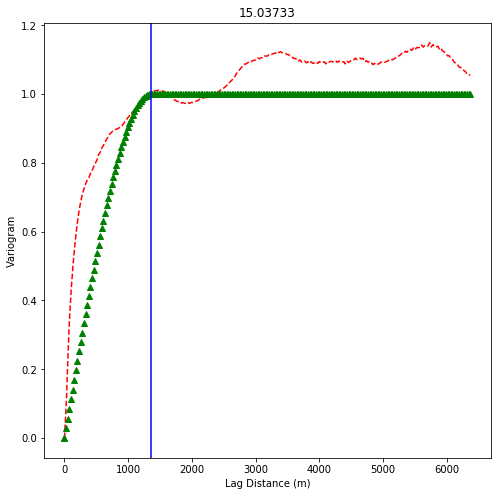

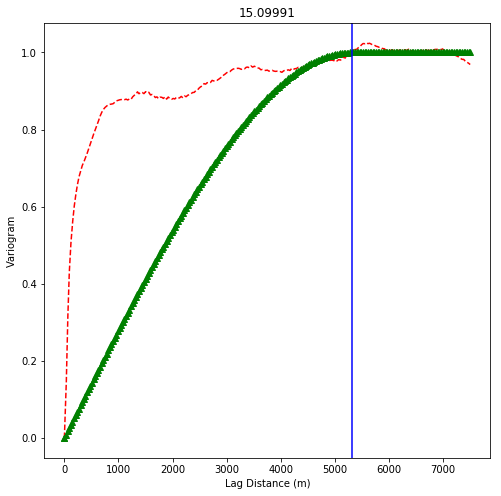

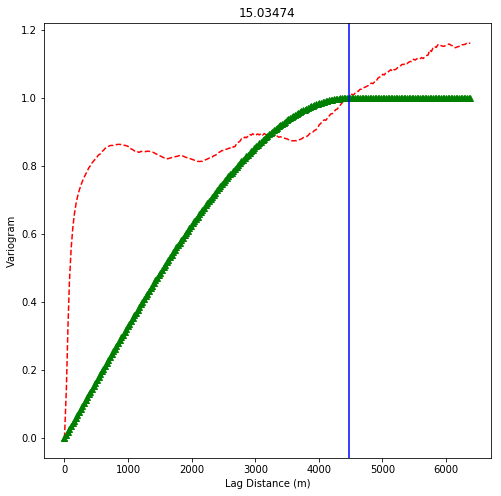

In [26]:
for i in range(len(fl)):
    dh_df=get_xyz(ma_list[i],gt_list[i],'dh',True)
    hrange=variogram(fl[i],dh_df,'x','y','dh',250,gt_list[i][1])
    std,nmad,dh_un=dh_er(ma_list[i],hrange,df_rgi,fl[i])
    dicti={'RGIId':fl[i],'std':std,'nmad':nmad,'dh_un':dh_un}
    df_temp=pd.DataFrame(dicti,index=[0])
    if i==0:
        df_error=df_temp.copy()
    else:
        df_error=df_error.append(df_temp,ignore_index=True)

In [46]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical(X,tpl):
    i=0
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y

In [45]:
np.shape(lag)

(252,)

In [28]:
#https://stackoverflow.com/questions/19791581/how-to-use-leastsq-function-from-scipy-optimize-in-python-to-fit-both-a-straight
#constants_spherical, _ = curve_fit(spherical,x,y)
# x = lag
# y=spherical(x, *constants_spherical)

In [12]:
df=get_xyz(ma_list[0],gt_list[0],'dh')

In [13]:
lag,gamma,npair=GeostatsPy.gamv_2d(df,'x','y','dh',250,25.34,0,90,0)

In [16]:
error_func=lambda tpl,x,y: spherical(x,tpl)-y

In [55]:
tpl_init=(0.0,80.0,300.0)

In [56]:
tpl_final,success=leastsq(error_func,tpl_init[:],args=(lag,gamma))

In [57]:
tpl_final

array([ -1.17328227,  44.07798057, 638.56511048])

In [58]:
success

1

In [95]:
tpl_final1=least_squares(error_func,tpl_init[:],bounds=((0,0,0),(10,np.max(gamma),np.max(lag))),args=(lag,gamma))

In [71]:
tpl_final1

 active_mask: array([-1,  0,  0])
        cost: 17474.01956219924
         fun: array([ 0.00000000e+00,  0.00000000e+00,  9.99233977e-01,  5.31857138e-01,
        1.65445986e-01,  3.75316733e-02,  8.54553318e-02,  1.59794893e-01,
        3.10329691e-01,  5.27532210e-01,  7.74366194e-01,  9.88275074e-01,
        1.11239871e+00,  1.19048650e+00,  1.21808085e+00,  1.08003944e+00,
        9.13071271e-01,  5.27245775e-01,  1.12106484e-01, -2.67760109e-01,
       -9.78310102e-01, -1.47827057e+00, -2.19146100e+00, -2.66694473e+00,
       -3.17088698e+00, -3.99712827e+00, -4.83740776e+00, -5.95027412e+00,
       -6.99706412e+00, -7.67691412e+00, -8.46511412e+00, -9.45805412e+00,
       -9.88349412e+00, -1.04466641e+01, -1.10740141e+01, -1.10777041e+01,
       -1.13783541e+01, -1.11734841e+01, -1.08418041e+01, -1.09560541e+01,
       -1.09669741e+01, -1.09096741e+01, -1.06585341e+01, -1.06288041e+01,
       -1.05610241e+01, -1.00993341e+01, -1.00074741e+01, -9.94747412e+00,
       -9.41153412e+

In [63]:
tpl_init

(0.0, 80.0, 300.0)

In [72]:
df1=get_xyz(ma_list[2],gt_list[2],'dh')

In [73]:
lag1,gamma1,npair1=GeostatsPy.gamv_2d(df1,'x','y','dh',250,25.34,0,90,0)

In [77]:
tpl_init1=(0.0,160,1000)

In [82]:
tpl_final11=least_squares(error_func,tpl_init1[:],bounds=((0,0,0),(np.max(gamma1),np.max(gamma1),np.max(lag1))),args=(lag1,gamma1))

In [84]:
lag_m11,gamma_m11=GeostatsPy.vmodel_2d(250,25.34,0,43.86,1,1,101.89,0,601.862,1)

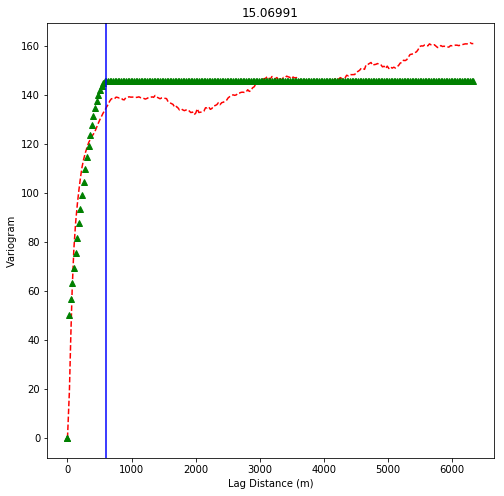

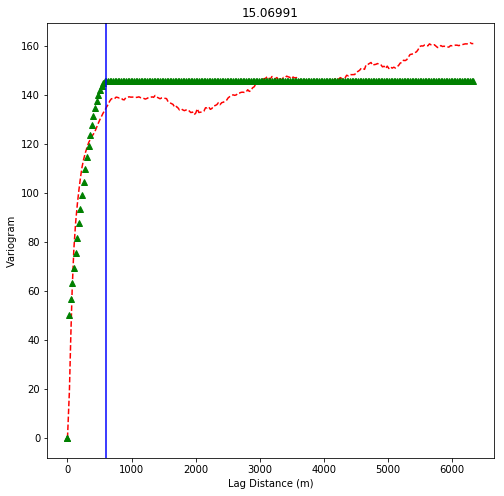

In [85]:
vario_plt(lag1,gamma1,lag_m11,gamma_m11,601.86,'15.06991')

In [86]:
df2=get_xyz(ma_list[3],gt_list[3],'dh')

In [87]:
lag2,gamma2,npair2=GeostatsPy.gamv_2d(df2,'x','y','dh',250,25.34,0,90,0)

In [88]:
gt_list

[(187223.976648235,
  25.531882649227317,
  0.0,
  -884420.177344021,
  0.0,
  -25.531882649227317),
 (176014.820986603,
  25.463679396611195,
  0.0,
  -894948.280472094,
  0.0,
  -25.463679396611195),
 (169621.913414148, 30.0, 0.0, -882452.705689766, 0.0, -30.0),
 (155946.087422037,
  25.522329298325264,
  0.0,
  -889408.804862529,
  0.0,
  -25.522329298325264)]

In [89]:
tpl_init2=(0.0,160,1000)
tpl_final22=least_squares(error_func,tpl_init2[:],bounds=((0,0,0),(np.max(gamma2),np.max(gamma2),np.max(lag2))),args=(lag2,gamma2))

In [91]:
tpl_final22.x

array([ 51.08172565,  97.11098306, 538.157242  ])

In [93]:
gamma_m22=spherical(lag2,tuple(tpl_final22.x))

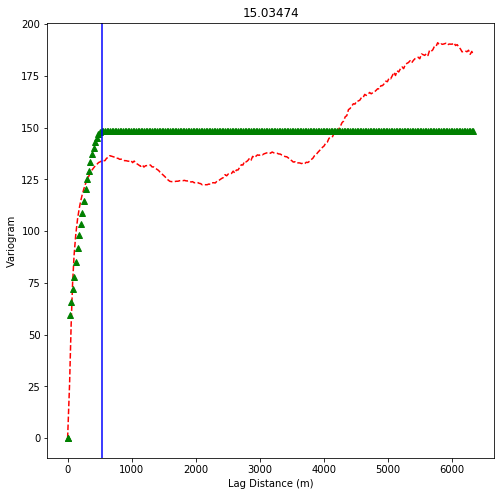

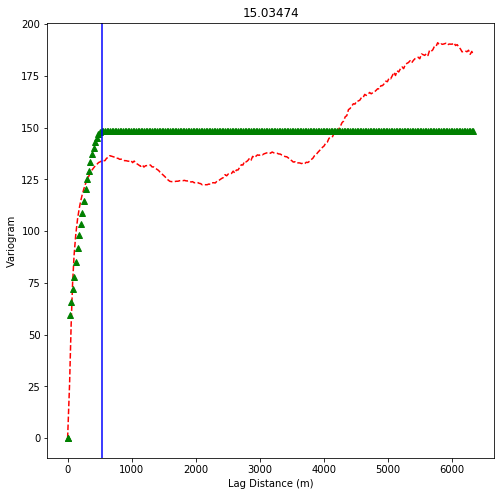

In [94]:
vario_plt(lag2,gamma2,lag2,gamma_m22,tpl_final22.x[-1],fl[-1])